# Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: <https://drive.google.com/file/d/1dfbAsM9DwA7tYhInyflIpZnYs7VT-0AQ/view> 

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # Unlimited columns
import seaborn as sns
from sklearn.preprocessing import RobustScaler

# Cleaning

In [106]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.drop(columns = 'customerID')
df.TotalCharges = df.TotalCharges.replace(' ', 0.0)
df.TotalCharges = df.TotalCharges.astype(float)
df.tenure = df.tenure.astype(float)
df = pd.get_dummies(df)

# Normalize the numerical columns
numericals = df[['tenure', 'MonthlyCharges', 'TotalCharges']].copy()
scaler = RobustScaler()
numericals = pd.DataFrame(scaler.fit_transform(numericals), columns=numericals.columns)
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = numericals
df.shape

(7043, 47)

In [113]:
y = df.Churn_Yes.values
X = df.drop(columns = ['Churn_No','Churn_Yes']).values

# 1. Baseline multi-level perceptron
And also optimizing epochs, by looking at the graph of accuracy over epoch.

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [5]:
%%time
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

# define the grid search parameters
batch_size = [20]
epochs = [20]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result1 = grid.fit(X, y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 3min 23s, sys: 6min 7s, total: 9min 30s
Wall time: 42.5 s


Best: 0.759 using {'batch_size': 20, 'epochs': 20}

Means: 0.759, Stdev: 0.046 with: {'batch_size': 20, 'epochs': 20}


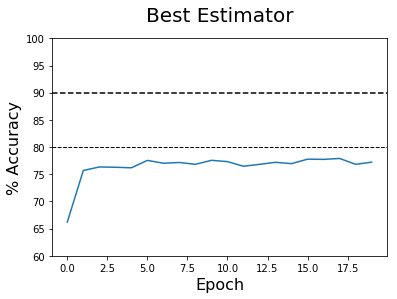

In [6]:
grid_result = grid_result1

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

Looks like this first iteration gives is 73% accuracy, and stops improving after 10 epochs at most.  I'll cut down the number of epochs for the next several optimization steps.

# 2. Optimize batch size

I first tried batch sizes of `batch_size = [10, 20, 40, 60, 80, 100]`, and found that `100` gave the best results.  At that point, realizing that I should generally be increasing my resolution with each step, I tried the following variations:

Tested: `[100, 300, 600, 900]`
Best: `100` one time, then `300` when run again.

Tested: `[90, 100, 150, 200, 250, 300]`
Best: `100`

I also confirmed with each printed accuracy plot that 10 epochs are still enough, and added a plot of accuracy vs the values of the optimized parameter (in this case, batch_size).


In [7]:
%%time
# define the grid search parameters
batch_size = [90, 100, 150, 200, 250, 300]
epochs = [10]
param_grid = dict(batch_size=batch_size, epochs=epochs)




# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result2 = grid.fit(X, y)

CPU times: user 1min 39s, sys: 2min 9s, total: 3min 49s
Wall time: 45.2 s


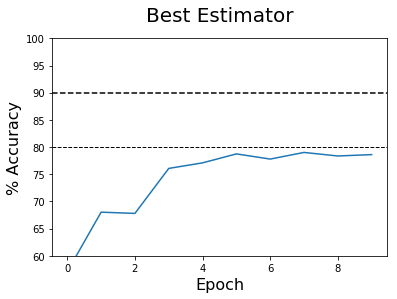

Best: 0.799 using {'batch_size': 100, 'epochs': 10}

Means: 74.003, Stdev: 4.560 with: {'batch_size': 90, 'epochs': 10}
Means: 79.909, Stdev: 0.766 with: {'batch_size': 100, 'epochs': 10}
Means: 75.351, Stdev: 5.100 with: {'batch_size': 150, 'epochs': 10}
Means: 78.390, Stdev: 0.419 with: {'batch_size': 200, 'epochs': 10}
Means: 75.706, Stdev: 3.218 with: {'batch_size': 250, 'epochs': 10}
Means: 75.025, Stdev: 4.086 with: {'batch_size': 300, 'epochs': 10}


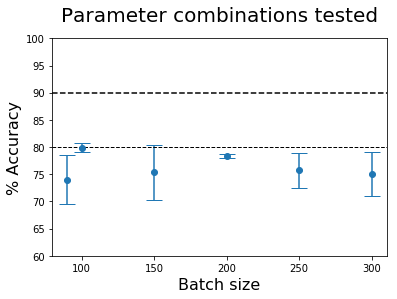

In [31]:
grid_result = grid_result2

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
batch_size = [x['batch_size'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Batch size', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.errorbar(batch_size, means, yerr=stds, fmt='o',
                 capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

What I've learned so far is that 10 epochs is still good enough, and I'll stick to a batch size of 100.

# 3. Optimize optimization algorithms

In [9]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
batch_size = [100]
epochs = [10]
optimizer = ['adam','sgd','rmsprop','nadam']
param_grid = dict(batch_size=batch_size, 
                  epochs=epochs,
                  optimizer=optimizer)
n_cv_splits = 5
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(12, input_dim=45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result3 = grid.fit(X, y)

CPU times: user 2min 58s, sys: 3min 48s, total: 6min 47s
Wall time: 1min 26s


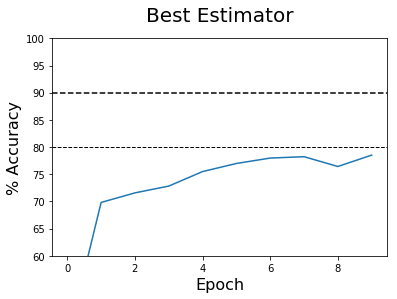

Best: 0.783 using {'batch_size': 100, 'epochs': 10, 'optimizer': 'adam'}

Means: 78.347, Stdev: 0.716 with: {'batch_size': 100, 'epochs': 10, 'optimizer': 'adam'}
Means: 73.463, Stdev: 0.013 with: {'batch_size': 100, 'epochs': 10, 'optimizer': 'sgd'}
Means: 78.078, Stdev: 0.947 with: {'batch_size': 100, 'epochs': 10, 'optimizer': 'rmsprop'}
Means: 78.220, Stdev: 2.229 with: {'batch_size': 100, 'epochs': 10, 'optimizer': 'nadam'}


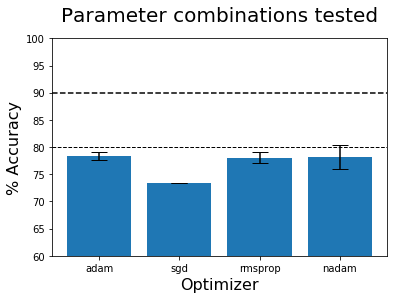

In [33]:
grid_result = grid_result3

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['optimizer'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Optimizer', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

Adam outperforms the other models slightly, so that's what we'll use from now on.

# 4. Optimize neurons in the hidden layer

In [35]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
# I moved settled parameters from the param_grid to the 
# model itself, to reduce clutter in the gridsearch
# parameter printout

n_neurons = [10, 20, 30, 40, 50, 60]
param_grid = dict(n_neurons=n_neurons)
n_cv_splits = 5
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(n_neurons):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result4 = grid.fit(X, y)

CPU times: user 6min 24s, sys: 6min 55s, total: 13min 19s
Wall time: 3min 31s


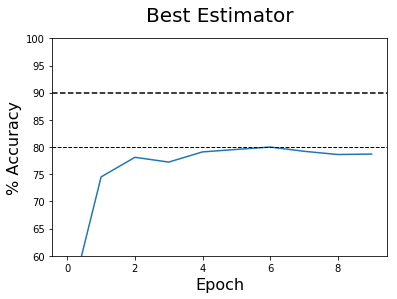

Best: 0.794 using {'n_neurons': 30}

Means: 74.968, Stdev: 8.110 with: {'n_neurons': 10}
Means: 77.439, Stdev: 5.355 with: {'n_neurons': 20}
Means: 79.370, Stdev: 1.354 with: {'n_neurons': 30}
Means: 76.842, Stdev: 5.644 with: {'n_neurons': 40}
Means: 79.313, Stdev: 0.874 with: {'n_neurons': 50}
Means: 76.090, Stdev: 5.588 with: {'n_neurons': 60}


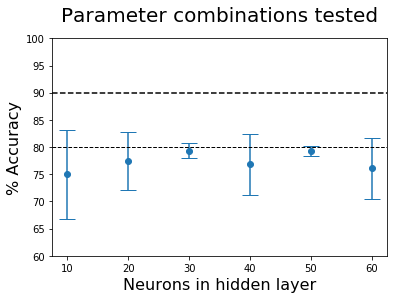

In [36]:
grid_result = grid_result4

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['n_neurons'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Neurons in hidden layer', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.errorbar(var, means, yerr=stds, fmt='o', capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

Alright, then, we're going with 30 neurons.

# 5. Optimize the number of hidden layers

In [38]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
# I moved settled parameters from the param_grid to the 
# model itself, to reduce clutter in the gridsearch
# parameter printout

n_hidden_layers = [1,2,3]
param_grid = dict(n_hidden_layers=n_hidden_layers)
n_cv_splits = 5
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(n_hidden_layers):
    model = Sequential()
    
    for i in range(n_hidden_layers):
        model.add(Dense(30, input_dim=45, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result5 = grid.fit(X, y)

CPU times: user 4min 30s, sys: 4min 24s, total: 8min 55s
Wall time: 2min 37s


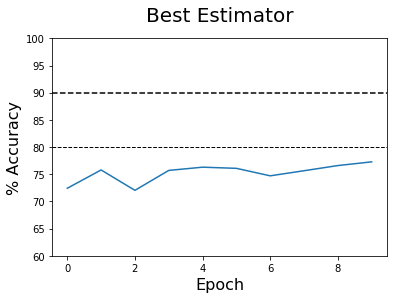

Best: 0.763 using {'n_hidden_layers': 2}

Means: 72.398, Stdev: 8.089 with: {'n_hidden_layers': 1}
Means: 76.260, Stdev: 2.610 with: {'n_hidden_layers': 2}
Means: 75.962, Stdev: 3.571 with: {'n_hidden_layers': 3}


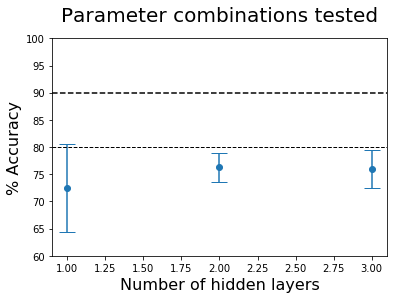

In [39]:
grid_result = grid_result5

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['n_hidden_layers'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Number of hidden layers', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.errorbar(var, means, yerr=stds, fmt='o', capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

# 6. Optimize the number of neurons again, but now with two layers
Note to self: Next time, try a couple of layer counts first.  At least previous results will inform my choice of neuron numbers. 

In [41]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
layer1_neurons = [30, 40, 50]
layer2_neurons = [30, 40, 50]
param_grid = dict(layer1_neurons=layer1_neurons,
                  layer2_neurons=layer2_neurons)
n_cv_splits = 5
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(layer1_neurons, layer2_neurons):
    model = Sequential()
    # Layer 1
    model.add(Dense(layer1_neurons, input_dim=45, activation='relu'))
    # Layer 2
    model.add(Dense(layer2_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result6 = grid.fit(X, y)

CPU times: user 15min 59s, sys: 11min 56s, total: 27min 56s
Wall time: 11min 3s


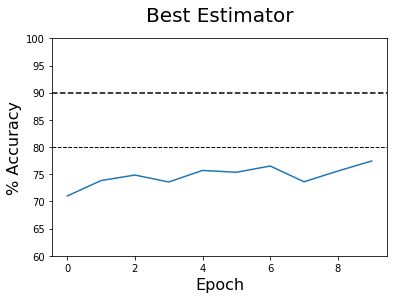

Best: 0.779 using {'layer1_neurons': 40, 'layer2_neurons': 40}

0 Means: 73.946, Stdev: 3.479 with: {'layer1_neurons': 30, 'layer2_neurons': 30}
1 Means: 73.761, Stdev: 3.714 with: {'layer1_neurons': 30, 'layer2_neurons': 40}
2 Means: 77.126, Stdev: 0.970 with: {'layer1_neurons': 30, 'layer2_neurons': 50}
3 Means: 75.280, Stdev: 1.499 with: {'layer1_neurons': 40, 'layer2_neurons': 30}
4 Means: 77.907, Stdev: 0.974 with: {'layer1_neurons': 40, 'layer2_neurons': 40}
5 Means: 76.785, Stdev: 0.609 with: {'layer1_neurons': 40, 'layer2_neurons': 50}
6 Means: 74.599, Stdev: 2.753 with: {'layer1_neurons': 50, 'layer2_neurons': 30}
7 Means: 75.422, Stdev: 2.806 with: {'layer1_neurons': 50, 'layer2_neurons': 40}
8 Means: 76.558, Stdev: 1.733 with: {'layer1_neurons': 50, 'layer2_neurons': 50}


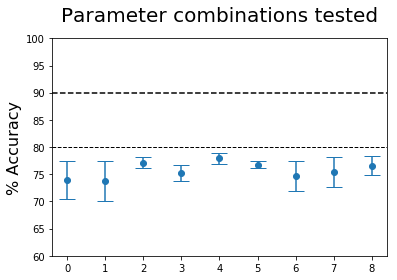

In [47]:
grid_result = grid_result6

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param, idx in zip(means, stds, params, var):
    print(f"{idx} Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

var = list(range(9))
fig, ax = plt.subplots()
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.errorbar(var, means, yerr=stds, fmt='o', capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

And the winner is 40 neurons in each layer!

# 7. Optimize learning rate

In [48]:
from keras import optimizers

In [ ]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
lr = [.001, .01, .1, .5]
param_grid = dict(lr=lr)
n_cv_splits = 5
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(lr):
    model = Sequential()
    model.add(Dense(40, input_dim=45, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    adam = optimizers.Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result7 = grid.fit(X, y)

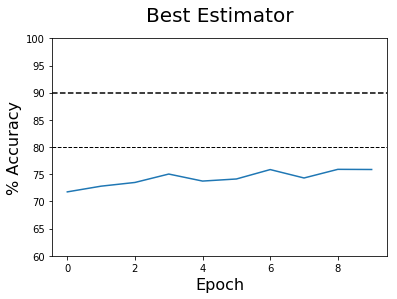

Best: 0.756 using {'lr': 0.001}

0 Means: 75.579, Stdev: 2.828 with: {'lr': 0.001}
1 Means: 65.086, Stdev: 18.308 with: {'lr': 0.01}
2 Means: 35.965, Stdev: 18.749 with: {'lr': 0.1}
3 Means: 35.922, Stdev: 18.770 with: {'lr': 0.5}


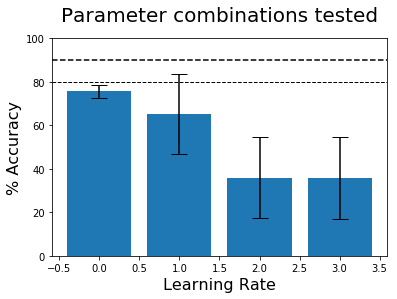

In [54]:
grid_result = grid_result7

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param, idx in zip(means, stds, params, var):
    print(f"{idx} Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = list(range(4))

fig, ax = plt.subplots()
ax.set_xlabel('Learning Rate', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

Stick with the default for Adam, `lr = 0.001`

# 8. Optimize momentum
This is only a parameter with SGD, so I'll switch the optimizer to that.

In [58]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
momentum = [0.1, 0.5, 0.8, 0.9]
param_grid = dict(momentum=momentum)
n_cv_splits = 5
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(momentum):
    model = Sequential()
    model.add(Dense(40, input_dim=45, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = optimizers.SGD(momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result8 = grid.fit(X, y)

CPU times: user 10min 21s, sys: 5min 15s, total: 15min 36s
Wall time: 8min 2s


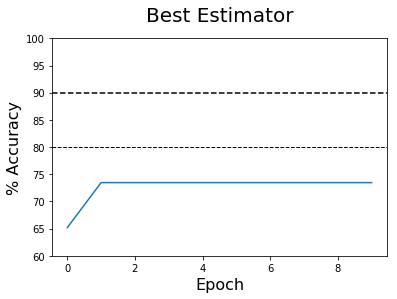

Best: 0.735 using {'momentum': 0.9}

0 Means: 54.764, Stdev: 22.902 with: {'momentum': 0.1}
1 Means: 64.078, Stdev: 18.770 with: {'momentum': 0.5}
2 Means: 64.135, Stdev: 18.657 with: {'momentum': 0.8}
3 Means: 73.463, Stdev: 0.013 with: {'momentum': 0.9}


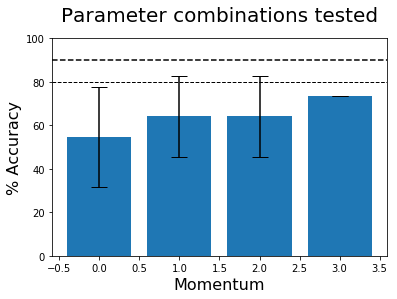

In [64]:
grid_result = grid_result8

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param, idx in zip(means, stds, params, var):
    print(f"{idx} Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = list(range(4))

fig, ax = plt.subplots()
ax.set_xlabel('Momentum', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(0,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

SGD worked generally worse than Adam, and worked better with the default momentum.  That will show me to try random things without an expectation that they'll work better.

# 9. Optimize activations

In [67]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
activation = ['relu','sigmoid','linear']
param_grid = dict(activation=activation)
n_cv_splits = 5
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(activation):
    model = Sequential()
    model.add(Dense(40, input_dim=45, activation=activation))
    model.add(Dense(40, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result9 = grid.fit(X, y)

CPU times: user 8min 21s, sys: 3min 12s, total: 11min 34s
Wall time: 6min 59s


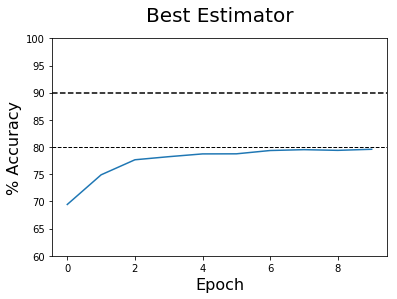

Best: 0.785 using {'activation': 'sigmoid'}

Means: 75.593, Stdev: 1.847 with: {'activation': 'relu'}
Means: 78.489, Stdev: 2.168 with: {'activation': 'sigmoid'}
Means: 76.147, Stdev: 0.470 with: {'activation': 'linear'}


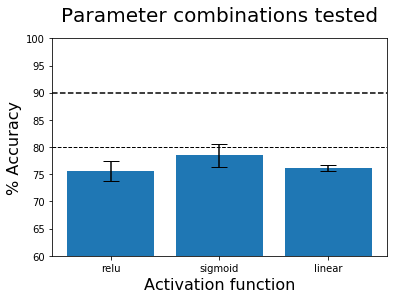

In [68]:
grid_result = grid_result9

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['activation'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Activation function', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

I'll be damned, this actually performed better with sigmoid.  I guess I'll start using that now.

# 10. Optimize network weight initializations

In [119]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
init = ['uniform','normal','glorot_normal']
param_grid = dict(init=init)
n_cv_splits = 3
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(init):
    model = Sequential()
    model.add(Dense(40, input_dim=45, activation='sigmoid',
                   kernel_initializer=init))
    model.add(Dense(40, activation='sigmoid', kernel_initializer=init))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result10 = grid.fit(X, y)

CPU times: user 5min 29s, sys: 1min 23s, total: 6min 53s
Wall time: 4min 42s


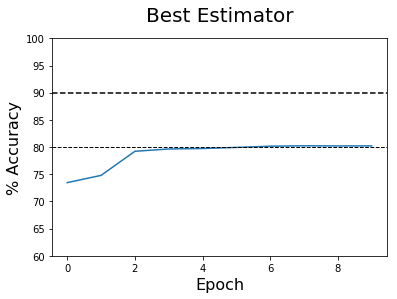

Best: 0.799 using {'init': 'glorot_normal'}

Means: 79.412, Stdev: 0.947 with: {'init': 'uniform'}
Means: 79.441, Stdev: 0.806 with: {'init': 'normal'}
Means: 79.938, Stdev: 0.707 with: {'init': 'glorot_normal'}


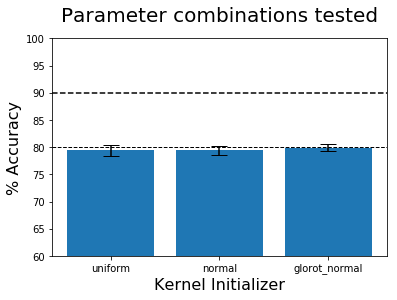

In [120]:
grid_result = grid_result10

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['init'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Kernel Initializer', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

These are basically identical, so I'll stick to the default.

# 11. Optimize dropout regularization

In [137]:
from keras.layers import Dropout

In [141]:
%%time
# Parameters that I changed for this optimization
# -----------------------------------------------
reg = [0.1, 0.2, 0.5]
param_grid = dict(reg=reg)
n_cv_splits = 3
# -----------------------------------------------


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model(reg):
    model = Sequential()
    model.add(Dense(40, input_dim=45, activation='sigmoid'))
    model.add(Dropout(reg))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dropout(reg))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=100, epochs=10)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=seed)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=kfold)

# Fit
grid_result11 = grid.fit(X, y)

CPU times: user 6min 30s, sys: 1min 50s, total: 8min 21s
Wall time: 5min 39s


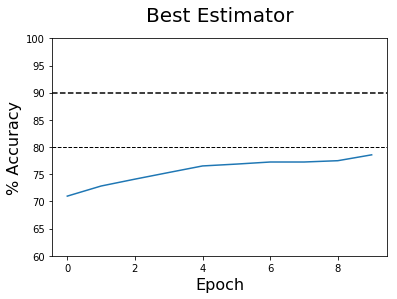

Best: 0.796 using {'reg': 0.5}

Means: 79.639, Stdev: 0.856 with: {'reg': 0.1}
Means: 79.597, Stdev: 1.120 with: {'reg': 0.2}
Means: 79.639, Stdev: 1.040 with: {'reg': 0.5}


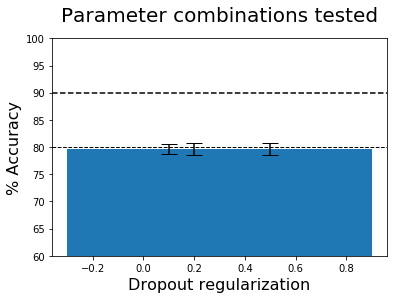

In [142]:
grid_result = grid_result11

# Plot the accuracy of the best estimator in the gridsearch
acc = [x*100 for x in grid_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")
print()
means = [x*100 for x in grid_result.cv_results_['mean_test_score']]
stds = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 

# Plot the accuracy of all the things tried in this gridsearch
var = [x['reg'] for x in params]

fig, ax = plt.subplots()
ax.set_xlabel('Dropout regularization', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
ax = plt.bar(var, means, yerr=stds, capsize=8)
plt.title('Parameter combinations tested', fontsize=20, y=1.05)
plt.show()

All the values give the same results.  Not bad.

## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?